In [1]:
from matplotlib import pyplot as plt
import numpy as np

data = np.load('data/lhq_256/24_classes_rbg.npy')


In [10]:
np.unique(data[:760].reshape((-1, 3)), axis=0).shape

(25, 3)

In [ ]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from skimage import io, transform, color
import requests
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from typing import List
from dataset import parse_csv
from tqdm import tqdm
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

In [ ]:
"""
150 classes
we need:
1. sky (2)
2. tree (4)
3. grass (9)
4. earth;ground (13)
5. mountain;mount (16)
6. plant;flora;plant;life (17)
7. sea (27)
8. 
"""

def image_to_mask(images, model, feature_extractor) -> List[np.ndarray]:
    inputs = feature_extractor(images=images, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    data: np.ndarray = np.array(logits.detach().numpy()).transpose((0, 2, 3, 1))
    image_mask = np.argmax(data, axis=-1, keepdims=True)
    return image_mask.astype(np.uint8)

def read_images(paths):
    return [io.imread(p) for p in paths]

classes = parse_csv()

files = glob('./data/lhq_256/images/*.png')
batch = 64
for i in tqdm(range(0, len(files), batch)):
    paths = files[i:i+batch]
    images = [io.imread(p) for p in paths]
    masks = image_to_mask(images, model, feature_extractor)
    for k in range(len(masks)):
        name = paths[k].replace('images', 'annotations_128')
        io.imsave(name, masks[k], check_contrast=False)

In [ ]:
import multiprocessing
import itertools
from typing import List
import numpy as np
import pandas as pd
from glob import glob

def parse_csv(path: str = 'data/ADE20K/included_classes.csv', sep: str = ';'):
    csv = pd.read_csv(path, sep=sep)
    classes = {}
    for index, (name, inc) in enumerate(zip(csv['Name'], csv['Include'])):
        if inc:
            classes[name] = index
    return classes    



if __name__ == '__main__':
    classes = parse_csv()


In [2]:
import numpy as np
import cv2
from tqdm import tqdm
from tqdm import tqdm
from dataset import generate_colors
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, maximum_filter

maps = np.load('data/lhq_256/24_classes.npy')
for i in tqdm(range(len(maps))):
    fmaps = cv2.medianBlur(maps[i], 13)[..., np.newaxis]
    unique, counts = np.unique(fmaps, return_counts=True)
    pmax_val = unique[np.argmax(counts)]
    for u, c in zip(unique, counts):
        if c < 1000:
            fmaps[fmaps == u] = 0
    fmaps = maximum_filter(fmaps, 5)            
    maps[i] = fmaps
    
np.save('data/lhq_256/24_classes_median.npy', maps)

classes = 24
d256 = maps
data = np.zeros((*d256.shape[:3], 3), dtype=np.uint8)
vals = generate_colors(classes)
for i in tqdm(range(len(d256))):
    for c in range(1, classes + 1):
        data[i][d256[i, ..., 0] == c] = vals[c - 1]
    
np.save('data/lhq_256/24_classes_rgb_median.npy', data)


100%|██████████| 90000/90000 [01:59<00:00, 750.91it/s]


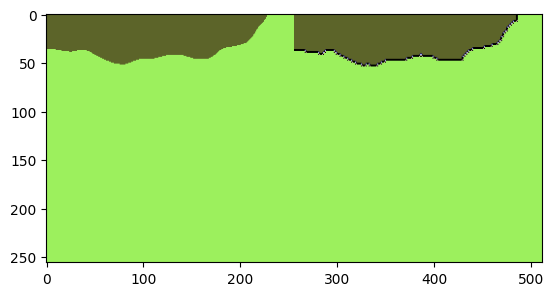

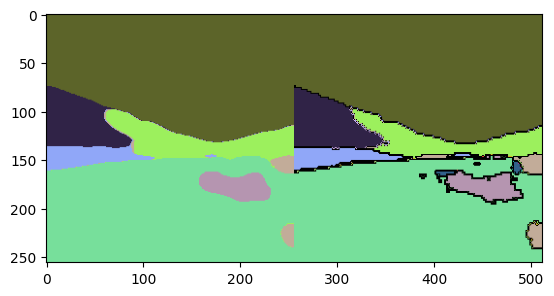

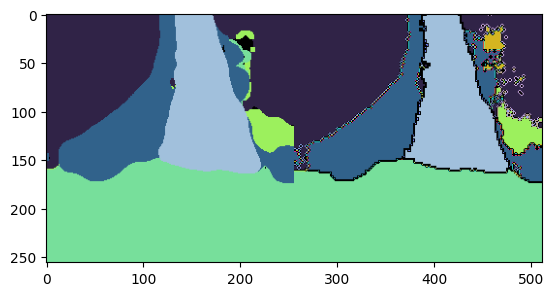

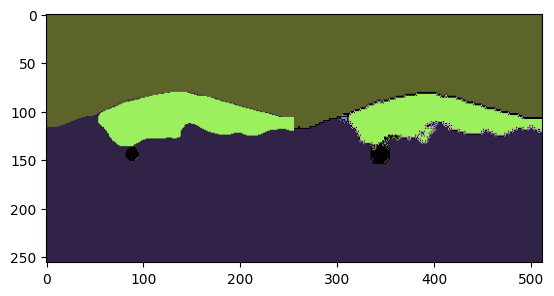

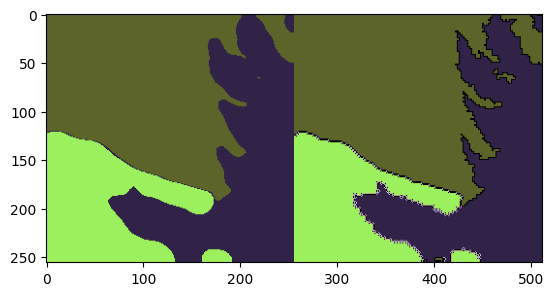

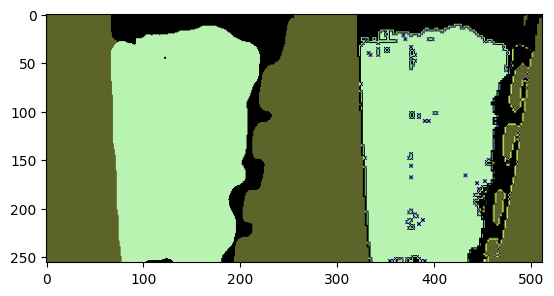

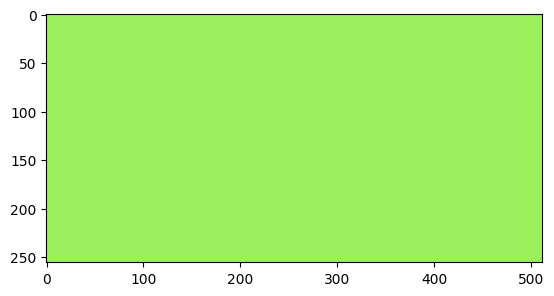

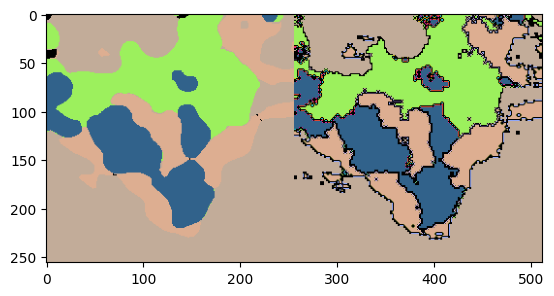

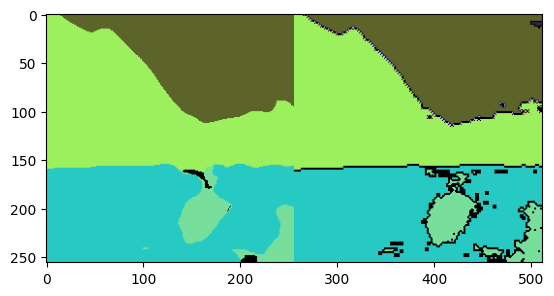

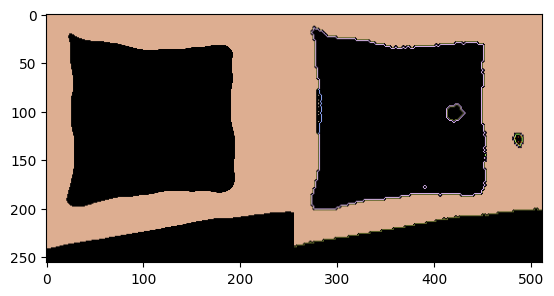

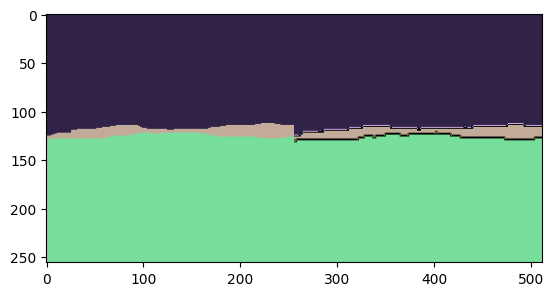

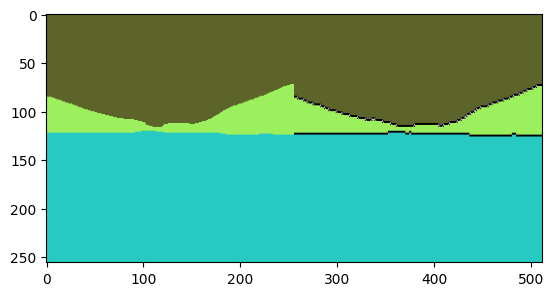

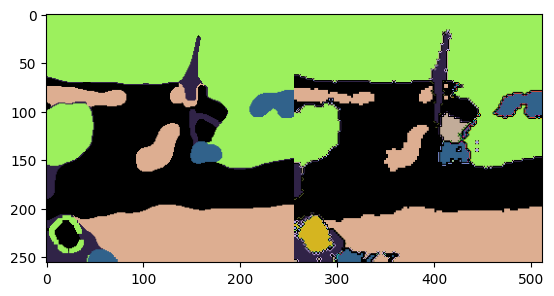

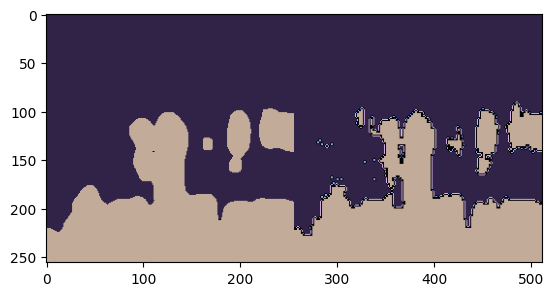

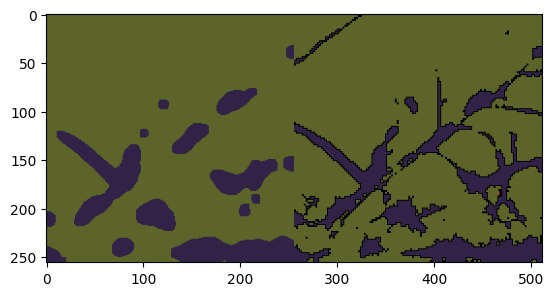

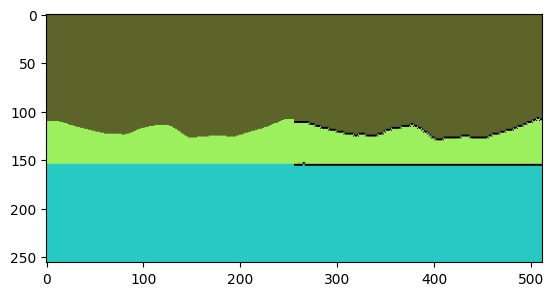

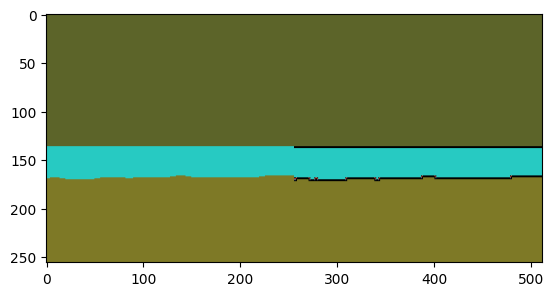

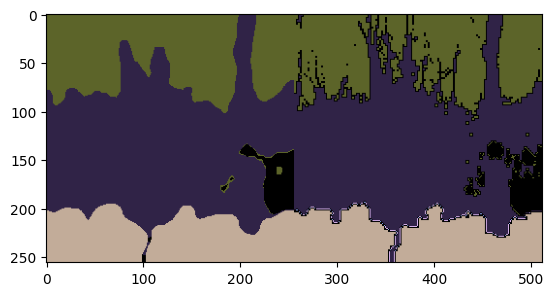

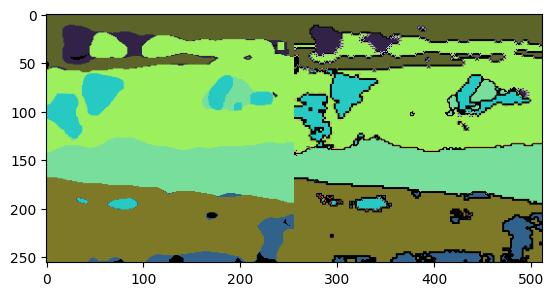

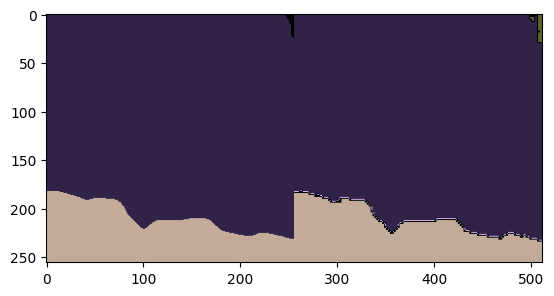

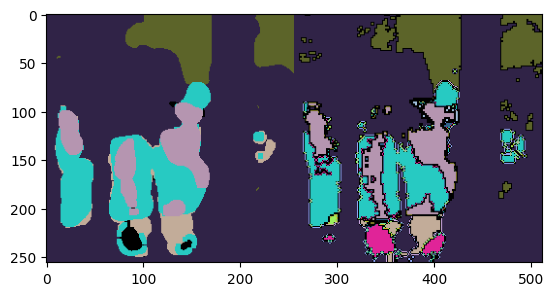

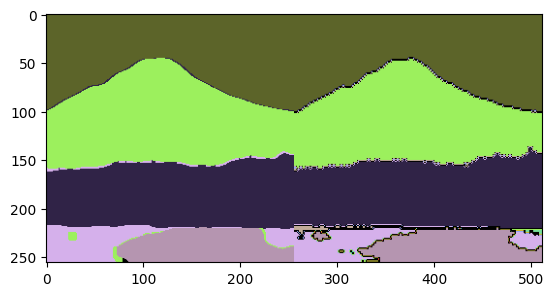

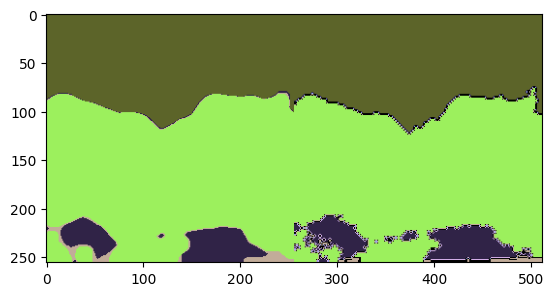

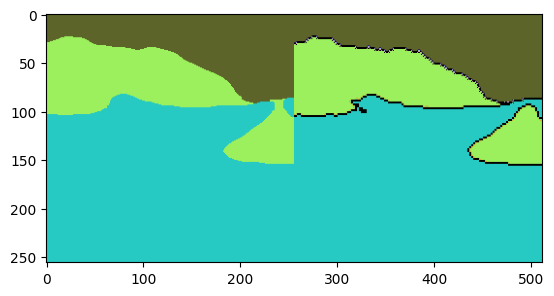

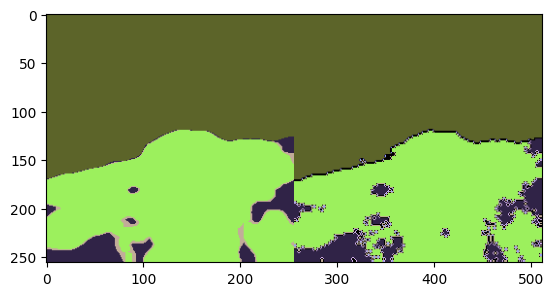

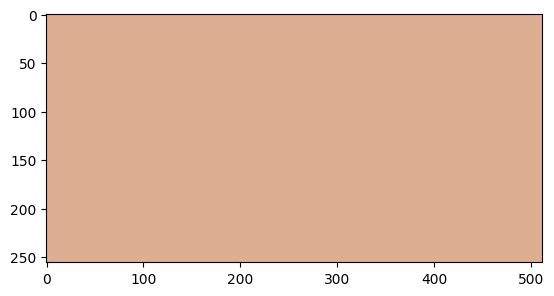

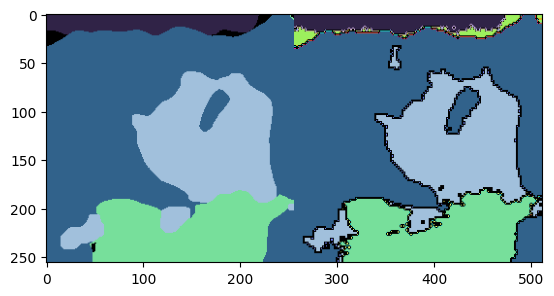

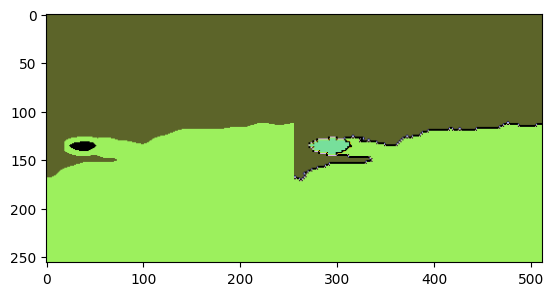

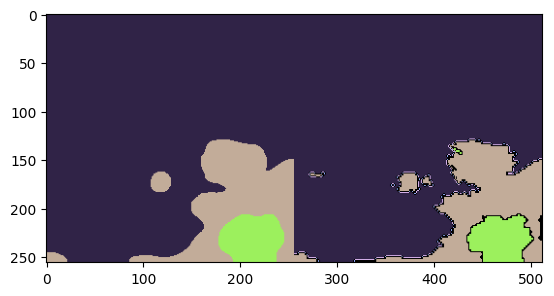

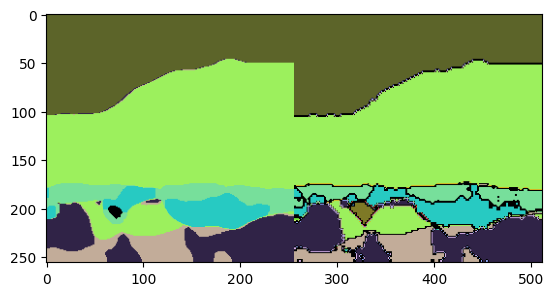

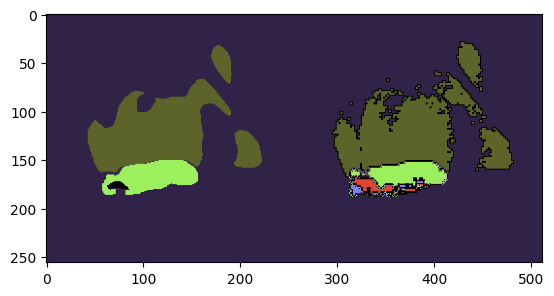

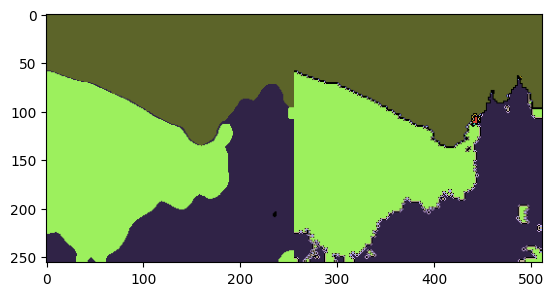

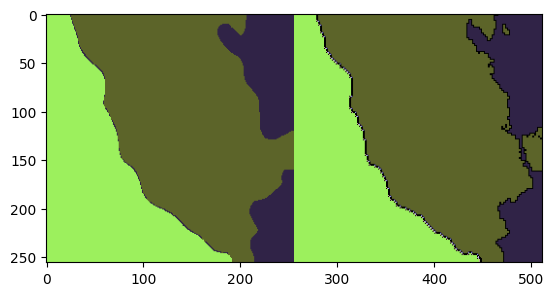

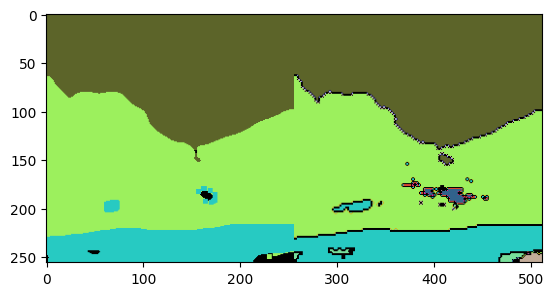

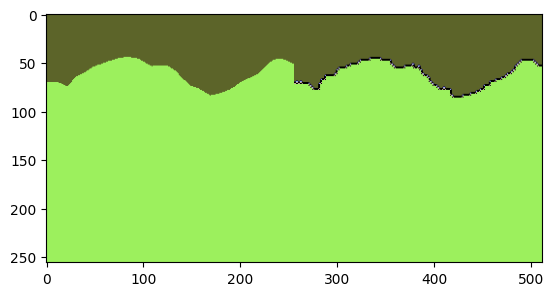

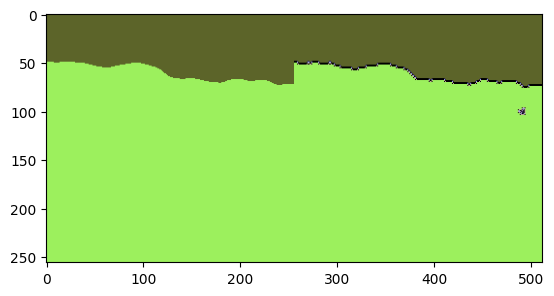

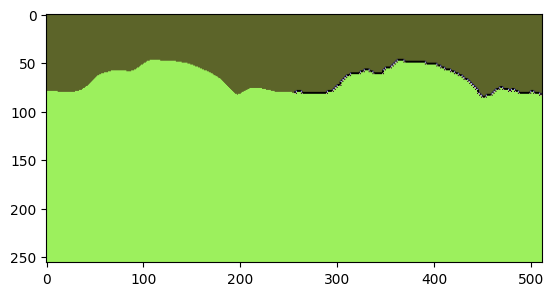

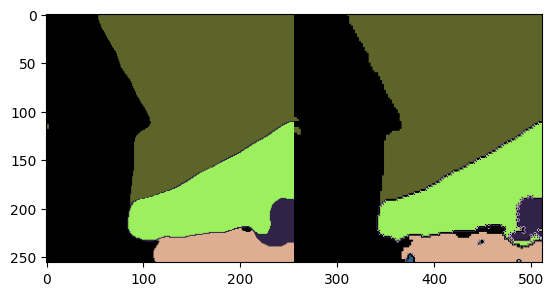

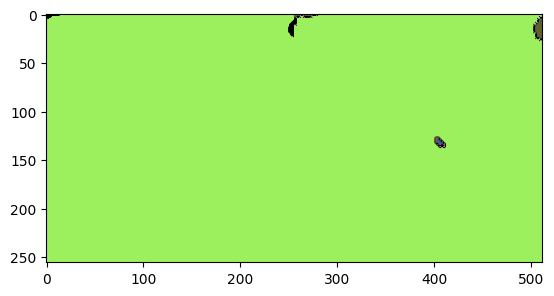

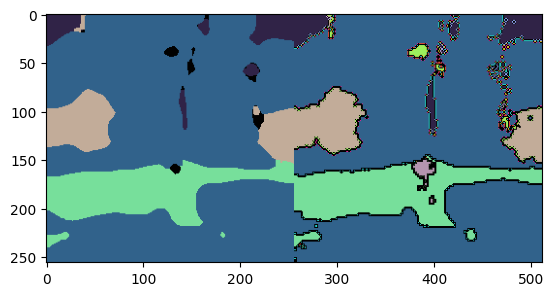

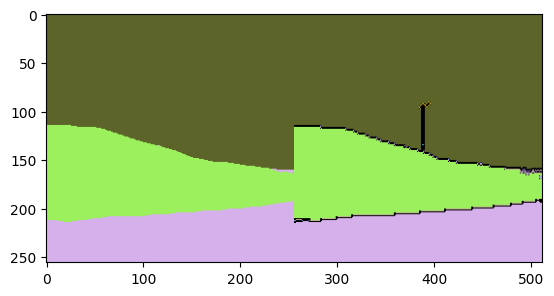

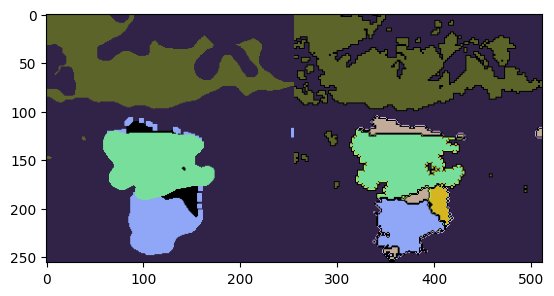

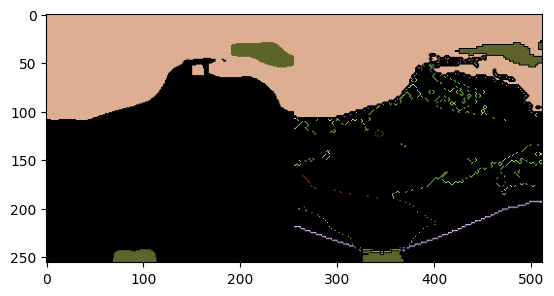

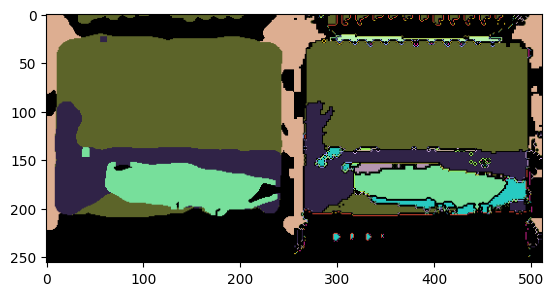

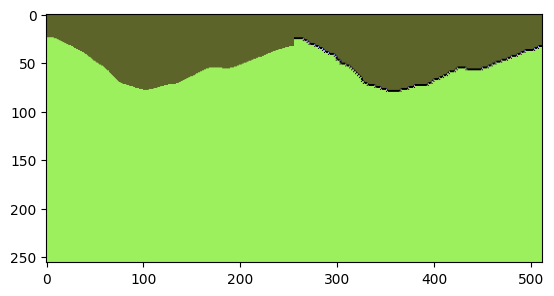

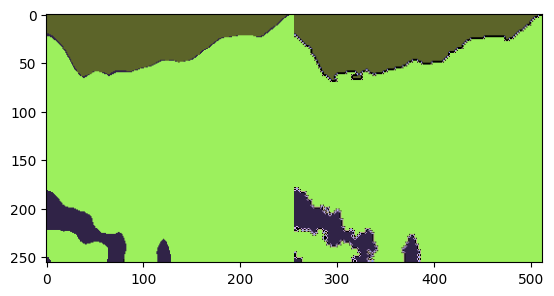

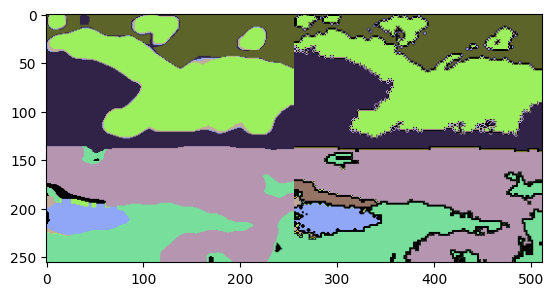

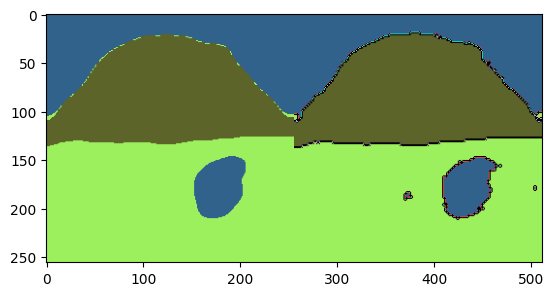

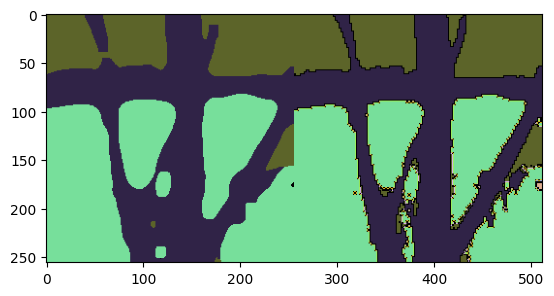

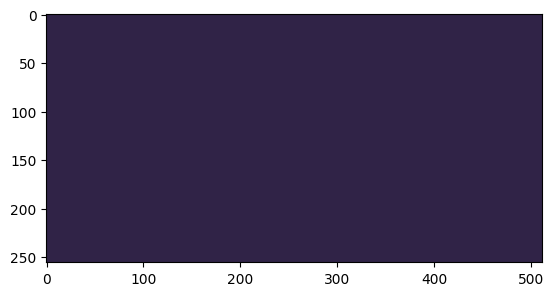

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

a1 = np.load('data/lhq_256/24_classes_rgb_median.npy')
a2 = np.load('data/lhq_256/24_classes_rgb.npy')

for i in range(50):
    plt.imshow(np.hstack([a1[i], a2[i]]))
    plt.show()